In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import truncnorm

2023-04-24 11:20:21.115687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class MetaDataset:
    def __init__(self, random_state=None):
        if random_state is None:
            self.random_state = np.random
        else:
            self.random_state = random_state

    def generate_meta_train_data(self, n_tasks: int, n_samples: int) -> list:
        raise NotImplementedError

    def generate_meta_test_data(self, n_tasks: int, n_samples_context: int, n_samples_test: int) -> list:
        raise NotImplementedError

In [67]:
class moving_Sinc_MetaDataset(MetaDataset):

    def __init__(self, noise_std=0.05, ndim_x=2, random_state=None):
        self.noise_std = noise_std
        self.ndim_x = ndim_x
        self.x_low = -10
        self.x_high = 10
        super().__init__(random_state)

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            #X = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=2.5, size=(n_samples, self.ndim_x))
            mu1, mu2 = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=2.5, size=(2, self.ndim_x))
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples, self.ndim_x))
            Y = self._gp_fun_from_prior(X, mu1, mu2)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            #X = truncnorm.rvs(-10, 10, loc=0, scale=2.5, size=(n_samples_context + n_samples_test, self.ndim_x))
            mu1, mu2 = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=2.5, size=(2, self.ndim_x))
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples_context + n_samples_test, self.ndim_x))
            Y = self._gp_fun_from_prior(X, mu1, mu2)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples
    
    def sinc_mean(self, x, mu1, mu2):
        #loc1, loc2 = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=2.5, size=(2, self.ndim_x))
        sinc1 = np.sin(np.linalg.norm(x - mu1, axis=-1))/np.linalg.norm(x - mu1, axis=-1)
        sinc2 = np.sin(np.linalg.norm(x - mu2, axis=-1))/np.linalg.norm(x - mu2, axis=-1)
        return sinc1 + 2 * sinc2

    def _gp_fun_from_prior(self, X, mu1, mu2):
        assert X.ndim == 2

        n = X.shape[0]

        def kernel(a, b, lengthscale):
            sqdist = np.sum(a ** 2, 1).reshape(-1, 1) + np.sum(b ** 2, 1) - 2 * np.dot(a, b.T)
            return np.exp(-.5 * (1 / lengthscale) * sqdist)

        K_ss = kernel(X, X, 0.5)
        L = np.linalg.cholesky(K_ss + 1e-8 * np.eye(n))
        f = self.sinc_mean(X, mu1, mu2) #+ np.dot(L, self.random_state.normal(scale=0.2, size=(n, 1))).flatten()
        y = f + self.random_state.normal(scale=self.noise_std, size=f.shape)
        return y.reshape(-1, 1)

In [58]:
def provide_data(dataset, seed=28, n_train_tasks=None, n_samples=None, config=None):
    import numpy as np

    N_TEST_TASKS = 20
    N_VALID_TASKS = 20
    N_TEST_SAMPLES = 200

    # if specified, overwrite default settings
    if config is not None:
        if config['num_test_valid_tasks'] is not None: N_TEST_TASKS = config['num_test_valid_tasks']
        if config['num_test_valid_tasks'] is not None: N_VALID_TASKS = config['num_test_valid_tasks']
        if config['num_test_valid_samples'] is not None:  N_TEST_SAMPLES = config['num_test_valid_samples']
            
            
    elif 'cauchy' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = CauchyMetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    elif 'sinc' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = Sinc_MetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    elif 'movingaverages' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = moving_Sinc_MetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    else:
        raise NotImplementedError('Does not recognize dataset flag')

    data_train = dataset.generate_meta_train_data(n_tasks=n_train_tasks, n_samples=n_train_samples)

    data_test_valid = dataset.generate_meta_test_data(n_tasks=N_TEST_TASKS + N_VALID_TASKS,
                                                      n_samples_context=n_context_samples,
                                                      n_samples_test=N_TEST_SAMPLES)
    data_valid = data_test_valid[N_VALID_TASKS:]
    data_test = data_test_valid[:N_VALID_TASKS]

    return data_train, data_valid, data_test

In [80]:
class moving_Sinc_MetaDataset(MetaDataset):

    def __init__(self, noise_std=0.05, ndim_x=2, random_state=None):
        self.noise_std = noise_std
        self.ndim_x = ndim_x
        self.x_low = -5
        self.x_high = 5
        super().__init__(random_state)

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            mu1, mu2 = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=2.5, size=(2, self.ndim_x))
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples, self.ndim_x))
            Y = self._gp_fun_from_prior(X, mu1, mu2)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            mu1, mu2 = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=2.5, size=(2, self.ndim_x))
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples_context + n_samples_test, self.ndim_x))
            Y = self._gp_fun_from_prior(X, mu1, mu2)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples
    
    def sinc_mean(self, x, mu1, mu2):
        sinc1 = np.sin(np.linalg.norm(x - mu1, axis=-1))/np.linalg.norm(x - mu1, axis=-1)
        sinc2 = np.sin(np.linalg.norm(x - mu2, axis=-1))/np.linalg.norm(x - mu2, axis=-1)
        return sinc1 + 2 * sinc2

    def _gp_fun_from_prior(self, X, mu1, mu2):
        assert X.ndim == 2

        n = X.shape[0]

        def kernel(a, b, lengthscale):
            sqdist = np.sum(a ** 2, 1).reshape(-1, 1) + np.sum(b ** 2, 1) - 2 * np.dot(a, b.T)
            return np.exp(-.5 * (1 / lengthscale) * sqdist)

        K_ss = kernel(X, X, 0.5)
        L = np.linalg.cholesky(K_ss + 1e-8 * np.eye(n))
        f = self.sinc_mean(X, mu1, mu2)
        y = f + self.random_state.normal(scale=self.noise_std, size=f.shape)
        return y.reshape(-1, 1)

20
200


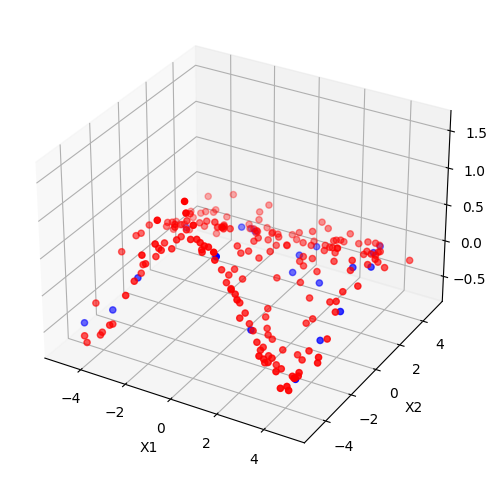

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

meta_train_data, meta_test_data, _ = provide_data(dataset='movingaverages_20', n_samples=20)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(1):
    X_context, Y_context, X_test, Y_test = meta_test_data[i]
    print(len(Y_context))
    print(len(Y_test))
    ax.scatter(X_context[:, 0], X_context[:, 1], Y_context, c='b', marker='o')
    ax.scatter(X_test[:, 0], X_test[:, 1], Y_test, c='r', marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

plt.show()

In [91]:
tf.get_logger().setLevel('ERROR')

#choose number of tasks here
meta_train_data, meta_test_data, _ = provide_data(dataset='movingaverages_20', n_train_tasks=20, n_samples=20)

from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, prior_weight=0.184, bandwidth=480.,
                                  hyper_prior_likelihood_log_var_mean_mean=-1.0,
                                  hyper_prior_log_var_mean=-1.74, hyper_prior_nn_std=0.12,
                                  hyper_prior_weight=1e-5, lr=1.5e-3, learn_likelihood=True,
                                  random_seed=28, num_iter_meta_train=20000)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=10000, log_period=1000, plot_period=5000)

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f" % (key, eval_metrics_mean[key], eval_metrics_std[key]))


2023-04-24 22:53:20.033708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 22:53:20.105952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 22:53:20.128658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [40,2]
	

Start meta-training -------------------- 


2023-04-24 23:00:29.426997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]



Iter 0/20000 - Time 473.04 sec - Train-Loss: -9315.06543

Iter 1000/20000 - Time 25.29 sec - Train-Loss: -329.43875

Iter 2000/20000 - Time 29.75 sec - Train-Loss: -330.80539

Iter 3000/20000 - Time 31.12 sec - Train-Loss: -695.07013

Iter 4000/20000 - Time 22.30 sec - Train-Loss: -315.87500

Iter 5000/20000 - Time 24.18 sec - Train-Loss: -333.93387

Iter 6000/20000 - Time 23.59 sec - Train-Loss: -236.26778

Iter 7000/20000 - Time 23.98 sec - Train-Loss: -199.86334

Iter 8000/20000 - Time 22.69 sec - Train-Loss: -96.18034

Iter 9000/20000 - Time 27.45 sec - Train-Loss: -58.92819


2023-04-24 23:05:55.262803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 23:05:55.574413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 23:05:55.590095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40,1]


	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----


2023-04-24 23:06:23.930219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 23:06:24.027094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16}}]]
2023-04-24 23:06:24.341334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this

	Meta-Test batch #2 consisting of 5 tasks----

Iter 10000/20000 - Time 29.57 sec - Train-Loss: -27.30375- Val-avg_ll: -0.237 +- 0.149- Val-avg_rmse: 0.321 +- 0.048- Val-cal_err: 0.053 +- 0.020

Iter 11000/20000 - Time 35.30 sec - Train-Loss: -13.39064

Iter 12000/20000 - Time 29.83 sec - Train-Loss: -10.99406

Iter 13000/20000 - Time 25.51 sec - Train-Loss: -13.27842

Iter 14000/20000 - Time 25.26 sec - Train-Loss: -11.36221

Iter 15000/20000 - Time 21.81 sec - Train-Loss: -7.07272

Iter 16000/20000 - Time 21.15 sec - Train-Loss: -8.63692

Iter 17000/20000 - Time 23.14 sec - Train-Loss: -9.97222

Iter 18000/20000 - Time 21.94 sec - Train-Loss: -7.17733

Iter 19000/20000 - Time 21.60 sec - Train-Loss: -7.31982


2023-04-24 23:16:12.848499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 23:16:12.876666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 23:16:12.889941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40,1]


	Start meta-test posterior inference in 4 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----


2023-04-24 23:16:13.277773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 23:16:13.286756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [40,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 23:16:13.298741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]

	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test batch #3 consisting of 5 tasks----
	Meta-Test batch #4 consisting of 5 tasks----
avg_ll: -0.2509 +- 0.1481
avg_rmse: 0.3202 +- 0.0568
cal_err: 0.0517 +- 0.0222


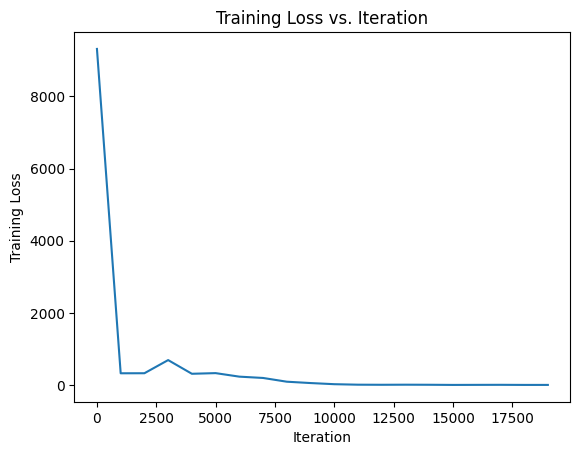

In [2]:
import matplotlib.pyplot as plt

# Training loss values
train_loss = [-9315.06543, -329.43875, -330.80539, -695.07013, -315.87500, 
              -333.93387, -236.26778, -199.86334, -96.18034, -58.92819, 
              -27.30375, -13.39064, -10.99406, -13.27842, -11.36221, 
              -7.07272, -8.63692, -9.97222, -7.17733, -7.31982]

train_loss = [- train_loss[i] for i in range(len(train_loss))]

# Iteration values
iterations = [i for i in range(0, 20000, 1000)]

# Plotting the train loss wrt. iteration
plt.plot(iterations, train_loss)
plt.title("Training Loss vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.show()


In [87]:
tf.get_logger().setLevel('ERROR')

#choose number of tasks here
meta_train_data, meta_test_data, _ = provide_data(dataset='movingaverages_20', n_train_tasks=20, n_samples=20)

from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, prior_weight=0.184, bandwidth=480.,
                                  hyper_prior_likelihood_log_var_mean_mean=-1.0,
                                  hyper_prior_log_var_mean=-1.74, hyper_prior_nn_std=0.12,
                                  num_hyper_posterior_particles=5, num_posterior_particles=5,
                                  hyper_prior_weight=1e-5, lr=1.5e-3, learn_likelihood=True,
                                  random_seed=28, num_iter_meta_train=20000)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=10000, log_period=1000, plot_period=5000)

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f" % (key, eval_metrics_mean[key], eval_metrics_std[key]))

2023-04-24 20:29:37.846852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 20:29:37.858418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 20:29:37.868938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	

Start meta-training -------------------- 


2023-04-24 20:30:09.920951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]



Iter 0/20000 - Time 61.84 sec - Train-Loss: -2977.99658

Iter 1000/20000 - Time 31.65 sec - Train-Loss: -303.53278

Iter 2000/20000 - Time 32.44 sec - Train-Loss: -319.63361

Iter 3000/20000 - Time 32.28 sec - Train-Loss: -534.78735

Iter 4000/20000 - Time 35.54 sec - Train-Loss: -295.75464

Iter 5000/20000 - Time 33.20 sec - Train-Loss: -266.80283

Iter 6000/20000 - Time 30.77 sec - Train-Loss: -208.23335

Iter 7000/20000 - Time 32.14 sec - Train-Loss: -157.46896

Iter 8000/20000 - Time 31.21 sec - Train-Loss: -63.00193

Iter 9000/20000 - Time 31.78 sec - Train-Loss: -43.39283


2023-04-24 20:36:19.984191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 20:36:20.001025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,2]
	 [[{{node Placeholder/_0}}]]
2023-04-24 20:36:20.013004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]


	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----


2023-04-24 20:36:39.268250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 20:36:39.350542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16}}]]
2023-04-24 20:36:39.501607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this

	Meta-Test batch #2 consisting of 5 tasks----

Iter 10000/20000 - Time 31.29 sec - Train-Loss: -17.80134- Val-avg_ll: -0.698 +- 0.308- Val-avg_rmse: 0.472 +- 0.095- Val-cal_err: 0.066 +- 0.027

Iter 11000/20000 - Time 52.86 sec - Train-Loss: -11.29696

Iter 12000/20000 - Time 32.81 sec - Train-Loss: -13.33517

Iter 13000/20000 - Time 31.16 sec - Train-Loss: -13.78785

Iter 14000/20000 - Time 31.85 sec - Train-Loss: -7.87209

Iter 15000/20000 - Time 32.04 sec - Train-Loss: -9.59181

Iter 16000/20000 - Time 31.89 sec - Train-Loss: -9.58050

Iter 17000/20000 - Time 31.49 sec - Train-Loss: -6.09209

Iter 18000/20000 - Time 31.35 sec - Train-Loss: -6.87439

Iter 19000/20000 - Time 33.81 sec - Train-Loss: -6.78313


2023-04-24 20:51:20.194280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 20:51:20.221290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 20:51:20.235839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]


2023-04-24 20:51:20.612825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [20]
	 [[{{node Placeholder/_0}}]]


	Start meta-test posterior inference in 4 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test batch #3 consisting of 5 tasks----
	Meta-Test batch #4 consisting of 5 tasks----
avg_ll: -0.6884 +- 0.2376
avg_rmse: 0.5094 +- 0.1276
cal_err: 0.0578 +- 0.0260


In [88]:
tf.get_logger().setLevel('ERROR')

#choose number of tasks here
meta_train_data, meta_test_data, _ = provide_data(dataset='movingaverages_20', n_train_tasks=5, n_samples=20)

from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, prior_weight=0.184, bandwidth=480.,
                                  hyper_prior_likelihood_log_var_mean_mean=-1.0,
                                  hyper_prior_log_var_mean=-1.74, hyper_prior_nn_std=0.12,
                                  num_hyper_posterior_particles=5, num_posterior_particles=5,
                                  hyper_prior_weight=1e-5, lr=1.5e-3, learn_likelihood=True,
                                  random_seed=28, num_iter_meta_train=20000)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=10000, log_period=1000, plot_period=5000)

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f" % (key, eval_metrics_mean[key], eval_metrics_std[key]))

2023-04-24 21:06:18.913886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 21:06:18.924047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 21:06:18.936100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	

Start meta-training -------------------- 


2023-04-24 21:06:49.904194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]



Iter 0/20000 - Time 58.88 sec - Train-Loss: -3299.61914

Iter 1000/20000 - Time 27.93 sec - Train-Loss: -304.37259

Iter 2000/20000 - Time 27.51 sec - Train-Loss: -320.04803

Iter 3000/20000 - Time 26.42 sec - Train-Loss: -527.53967

Iter 4000/20000 - Time 32.22 sec - Train-Loss: -296.45859

Iter 5000/20000 - Time 31.72 sec - Train-Loss: -267.79147

Iter 6000/20000 - Time 32.38 sec - Train-Loss: -208.07559

Iter 7000/20000 - Time 30.05 sec - Train-Loss: -156.49106

Iter 8000/20000 - Time 31.79 sec - Train-Loss: -65.42165

Iter 9000/20000 - Time 32.51 sec - Train-Loss: -45.02714


2023-04-24 21:12:38.556668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]
	 [[{{node Placeholder/_0}}]]
2023-04-24 21:12:38.568973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 21:12:38.582249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]


	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----


2023-04-24 21:12:55.741539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 21:12:55.801438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16}}]]
2023-04-24 21:12:55.907246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this

	Meta-Test batch #2 consisting of 5 tasks----

Iter 10000/20000 - Time 32.15 sec - Train-Loss: -16.78362- Val-avg_ll: -0.717 +- 0.297- Val-avg_rmse: 0.482 +- 0.094- Val-cal_err: 0.067 +- 0.031

Iter 11000/20000 - Time 51.74 sec - Train-Loss: -12.04937

Iter 12000/20000 - Time 30.95 sec - Train-Loss: -12.20446

Iter 13000/20000 - Time 32.14 sec - Train-Loss: -14.06148

Iter 14000/20000 - Time 31.16 sec - Train-Loss: -7.82876

Iter 15000/20000 - Time 31.10 sec - Train-Loss: -9.91718

Iter 16000/20000 - Time 32.28 sec - Train-Loss: -9.01787

Iter 17000/20000 - Time 32.03 sec - Train-Loss: -6.00642

Iter 18000/20000 - Time 30.14 sec - Train-Loss: -6.93342

Iter 19000/20000 - Time 32.38 sec - Train-Loss: -6.55271


2023-04-24 21:25:10.176442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]
	 [[{{node Placeholder/_0}}]]
2023-04-24 21:25:10.192390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-24 21:25:10.201283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]


	Start meta-test posterior inference in 4 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test batch #3 consisting of 5 tasks----
	Meta-Test batch #4 consisting of 5 tasks----
avg_ll: -0.6929 +- 0.2242
avg_rmse: 0.5054 +- 0.1143
cal_err: 0.0543 +- 0.0209
